In [42]:
import gym

import random
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import math
import random
import numpy as np
import pandas as pd
from collections import defaultdict

import copy

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count


import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

matplotlib.style.use('ggplot')

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

# Init Block

## Enviroment

In [94]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash
    
    def board_to_number(self, state):
        if len(state) == 0:
            return 0

        board_actions = [self.int_from_action(x) for x in state]
        initial = np.zeros(np.max(board_actions) + 1)

        for i in board_actions:
            initial[i] = 1

        return int("".join(str(i) for i in initial), 2)
    
    def encode_state(self, current_state):
        return (current_state[0],
                self.board_to_number(current_state[1]),
                current_state[2])

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1
        return self.getState()

In [28]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

In [26]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

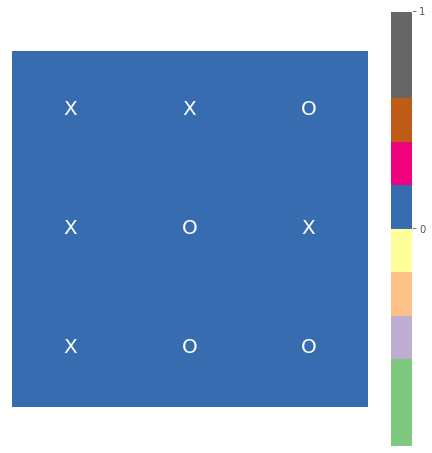

In [29]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

# Part 1. Tic Tac  Toe with Q-learning

In [118]:
class AgentQLearn:
    def __init__(self, env, alpha, gamma, epsilon=1.0):
        self._name = 'Q-Learning Agent'
        self.env = env
        self.action_size = 2
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.state_size = env.n_cols * env.n_rows
        self.Q = defaultdict(lambda : np.random.uniform(size=self.state_size).tolist())
        self.all_actions = self._init_all_actions()
        self.X_actions = list()
        self.X_states = list()
        
    @property
    def name(self):
        return self._name
    
    def _init_all_actions(self):
        self.env.reset()
        return self.env.getEmptySpaces().tolist()
    
    def _get_index(self, value):
        try:
            ind = self.all_actions.index(value)
            return ind
        except ValueError:
            return -1
    
    def update_Q(self, action, state):
        next_state, reward, done, _ = self.env.step(action) 

        if not done:
            reward = 0
        else:
            if env.curTurn == -1: # X win
                reward = 1
            else:
                reward = -1
                
            old_value = self.Q[self.X_states[-1]][self._get_index(list(self.X_actions[-1]))]
            next_max = np.max(self.Q[next_state[0]])

            new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
            self.Q[self.X_states[-1]][self._get_index(list(self.X_actions[-1]))] = new_value

            state = next_state
        
        if env.curTurn == 1:
            self.X_states.append(state[0])
            old_value = self.Q[state[0]][self._get_index(list(self.X_actions[-1]))]
            next_max = np.max(self.Q[next_state[0]])

            new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
            self.Q[state[0]][self._get_index(list(self.X_actions[-1]))] = new_value

            state = next_state
        return state, reward, done
        
    def make_action(self, state):
        actions = env.getEmptySpaces()
        if env.curTurn == -1:
            action = random.choice(actions)
        else:
            if np.random.random() < self.epsilon:
                action = random.choice(actions)
            else:
                while True:
                    ind = np.argmax(self.Q[state[0]])
                    action = self.all_actions[ind]
                    
                    if action not in actions:
                        self.Q[state[0]][self._get_index(action)] = -1000
                    else:
                        break
            self.X_actions.append(action)
        return action

In [139]:
import time
def run_experiment(env, alpha, gamma, epsilon, n_exp, window=500):
    start = time.time()
    agent = AgentQLearn(env, alpha, gamma, epsilon)
    rewards = list()
    for i in range(1, n_exp):
        state = env.reset()
        reward = 0
        done = False
        while not done:
            action = agent.make_action(state)
            state, reward, done = agent.update_Q(action, state)
        rewards.append(reward)

        if i % 2000 == 0:
            clear_output(wait=True)
            plt.figure()
            pd.Series(rewards).rolling(500).mean().plot()
            plt.show()
            plt.close()
    print(f"Evaluation completed in {time.time() - start:10.1f} seconds")

### 3x3

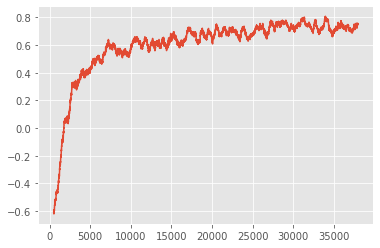

Evaluation completed in       23.4 seconds


In [140]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
run_experiment(env, 0.15, 0.9, 0.05, 40000)

### 4x4

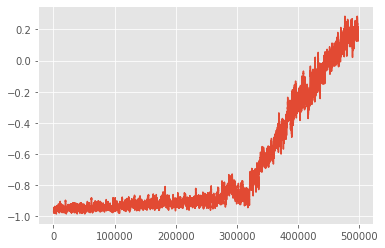

Evaluation completed in      506.7 seconds


In [141]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
run_experiment(env, 0.15, 0.9, 0.05, 500000, 2000)

It takes far more time to learn appropriate winning strategy because we are playing against random strategy, and on large desks it takes more steps to learn and harder to win, when every action of opponent is unpredictable and random.

## Adding neural networks

In [285]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [286]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [287]:
class Network(nn.Module):
    def __init__(self, n_cols, n_rows):
        nn.Module.__init__(self)
        self.conv_out_size = 5
        self.n_cols = n_cols
        self.n_rows = n_rows
        self.conv = nn.Conv2d(3, self.conv_out_size, kernel_size=3, stride=1, padding=1)
        self.l2 = nn.Linear(self.conv_out_size * n_cols * n_rows, n_cols * n_rows)

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = x.view(-1, self.conv_out_size * self.n_cols * self.n_rows)
        x = self.l2(x)
        return x

In [324]:
class AgentQLearn:
    def __init__(self, env, model, optim, gamma,
                 replay_memory_size=100000, batch_size=64,
                 eps_init=0.9, eps_final=0.05, eps_decay=400):
            self._name = 'DQN-Learning Agent'
            self.env = env
            self.action_size = 2
            self.model = model
            self.optimizer = optim
            self.gamma = gamma
            self.state_size = self.env.n_cols * self.env.n_rows
            self.memory = ReplayMemory(replay_memory_size)
            self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
            self.batch_size = batch_size
            self.num_step = 0

    @property
    def name(self):
        return self._name

    def encode_state_dqn(self, state):
        state_to_itterate = [int(i) for i in state[0]]
        result = np.zeros(( 3, self.env.n_cols, self.env.n_cols))

        for i in range(3):
            idx = np.where(np.array(state_to_itterate) == i)
            for id in idx[0]:
                result[i][id // self.env.n_cols][id % self.env.n_cols] = 1

        return result

    def select_greedy_action(self, state):
        return self.model(state).data.max(1)[1].view(1, 1)

    def make_action(self, state):
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if np.random.random() > eps_threshold:
            return self.select_greedy_action(state)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.int64)

    def run_episode(self, do_learning=True):

        self.env.reset()
        state = self.encode_state_dqn(self.env.getState())
        num_step = 0
        done = True
        x_plays = random.choice(range(self.action_size))  # select for whom we will play

        if not x_plays:
            state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
            state = self.encode_state_dqn(state)

        while not done:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            with torch.no_grad():
                action = self.make_action(state_tensor)
            value = self.env.action_from_int(action.numpy()[0][0])
            next_state, reward, done, _ = self.env.step(value)
            next_state = self.encode_state_dqn(next_state)
            next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            if not done:
                next_state, reward, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                next_state = self.encode_state_dqn(next_state)
                next_state_tensor = torch.tensor([next_state], dtype=torch.float32)

            if not x_plays:
                if reward in (-1, 1):
                    reward = reward * -1

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            if done:
                break

            state = next_state
            num_step += 1
            
    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state), requires_grad=True)
        batch_action = Variable(torch.cat(batch_action))
        batch_reward = Variable(torch.cat(batch_reward))
        batch_next_state = Variable(torch.cat(batch_next_state))

        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def evaluate_strategy(self, num_experiments=1000):
        total_reward = list()
        
        for i in range(num_experiments):
            total_reward.append(0)
            env_starts = random.choice([0, 1])
            
            self.env.reset()
            curr_state = self.encode_state_dqn(self.env.getState())

            if env_starts:
                curr_state, reward_opponent, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                curr_state = self.encode_state_dqn(curr_state)

            done = False
            while not done:

                curr_act = model(torch.tensor([curr_state], dtype=torch.float32)).data
                curr_act = np.argmax(curr_act.detach().numpy()[0])

                curr_state, reward_our_alg, done, _ = self.env.step(self.env.action_from_int(curr_act))
                curr_state = self.encode_state_dqn(curr_state)

                if env_starts:
                    if reward_our_alg == -1:
                        total_reward[-1] += 1
                    elif reward_our_alg == -10:
                        total_reward[-1] += reward_our_alg
                else:
                    total_reward[-1] += reward_our_alg

                if done:
                    break

                curr_state, reward_opponent, done, _ = self.env.step(random.choice(self.env.getEmptySpaces()))
                curr_state = self.encode_state_dqn(curr_state)

                if env_starts:
                    total_reward[-1] -= reward_opponent
                else:
                    total_reward[-1] += reward_opponent

                if done:
                    break
        self.env.close()
        return np.sum(total_reward)

In [336]:
N_EPOCHS = 7500
N_EXP = 300
EPS_INIT  = 0.9
EPS_FINAL = 0.05
EPS_DECAY = 5000
RM_SIZE = 100000
GAMMA = 0.92
BATCH_SIZE = 128
EXP_NUMBER = 1000

Starting training...



Evaluation completed in       62.5 seconds


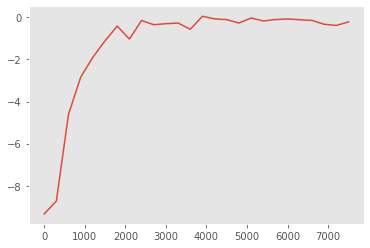

In [337]:
model = Network(N_COLS, N_ROWS)
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
optimizer = optim.Adam(model.parameters(), LR)
dqn = AgentQLearn(env, model, optimizer, GAMMA, RM_SIZE, batch_size=BATCH_SIZE,
                  eps_init=EPS_INIT, eps_final=EPS_FINAL, eps_decay=EPS_DECAY)

res = []
start = time.time()
print("Starting training...")
for e in tqdm(range(N_EPOCHS + 1)):
    dqn.run_episode()
    if e % N_EXP == 0:
        res.append(dqn.evaluate_strategy(EXP_NUMBER))
print(f"Evaluation completed in {time.time() - start:10.1f} seconds")
res = [number / EXP_NUMBER for number in res]
plt.plot(np.arange(0, N_EPOCHS + 1, N_EXP), res, label="dql")
plt.grid()
plt.show()